# WMT of tendency terms
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Make histogram of each term](#first-bullet)
* [Save histograms](#second-bullet)

# 1) Make histogram of each term <a class='anchor' id='first-bullet'> </a>

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
from xhistogram.xarray import histogram

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [4]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

tendencies = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tendencies.zarr')).drop(['nlon', 'nlat'])
tendencies

<xarray.Dataset>
Dimensions:    (time: 182, nlat: 2400, nlon: 3600)
Coordinates:
  * time       (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [5]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [6]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.35880f491d304bedaacccdec8d3a9edd/status,


In [34]:
client.close()
cluster.close()

In [7]:
rho_unsliced = fastjmd95.rho(ds.SSS, ds.SST, 0)
rho = rho_unsliced.isel(time=slice(0,182))

In [8]:
vol = ds.TAREA * ds.dz
delta_rho = 0.01
rho_bins = np.arange(1015, 1030, delta_rho)

In [87]:
tendency_terms = xr.merge([(tendencies.SST_bih*tendencies.drhodt).rename('sst'), 
                           (tendencies.SSS_bih*tendencies.drhods).rename('sss'), 
                            tendencies.rho_bih.rename('rho'), 
                            tendencies.cabbeling.rename('cabbeling')])

In [88]:
tendency_terms 

<xarray.Dataset>
Dimensions:    (time: 182, nlat: 2400, nlon: 3600)
Coordinates:
  * time       (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    sst        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    sss        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [89]:
all_tendencies = list(tendency_terms)

In [90]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=variable.fillna(0.), dim=['nlon', 'nlat'])
    return hist / delta_rho

In [91]:
histograms = xr.merge([histogram_func(tendency_terms[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])

In [92]:
histograms

<xarray.Dataset>
Dimensions:          (time: 182, rho0_bin: 1499)
Coordinates:
  * time             (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
Data variables:
    OMEGA_sst        (time, rho0_bin) float32 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float32 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_rho        (time, rho0_bin) float32 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_cabbeling  (time, rho0_bin) float32 dask.array<chunksize=(1, 1499), meta=np.ndarray>

In [22]:
temp = ds.SST.isel(time=slice(0,182))

In [52]:
mask = (temp[0]!=temp[0].isnull())

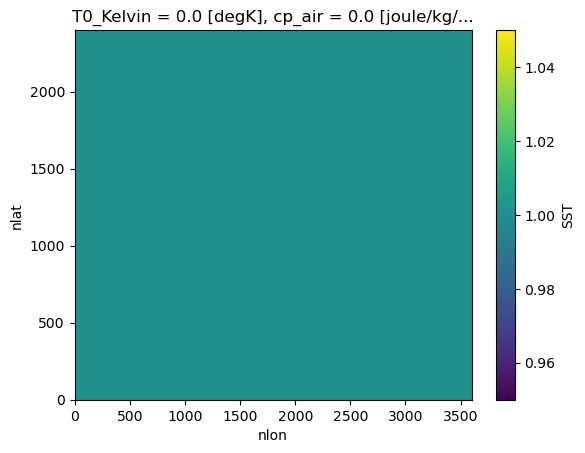

In [54]:
mask.plot()

In [53]:
mask

<xarray.DataArray 'SST' (nlat: 2400, nlon: 3600)>
dask.array<ne, shape=(2400, 3600), dtype=bool, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Coordinates: (12/52)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 0.0
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    time                object 0046-01-02 00:00:00
    vonkar              float64 0.0
Dimensions without coordinates: nlat, nlon

In [48]:
int(2 == 1)

0

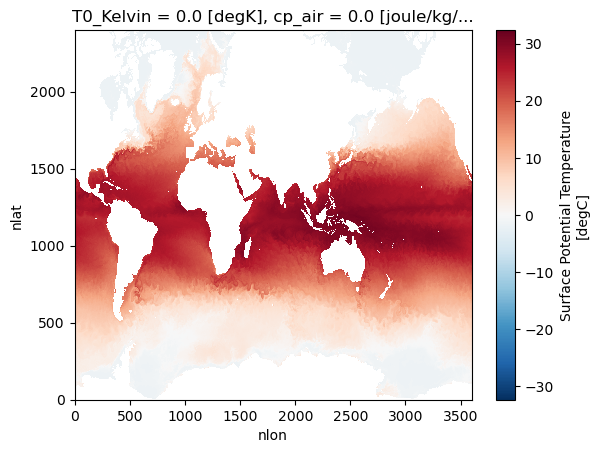

In [57]:
temp.where(mask)[0].plot()

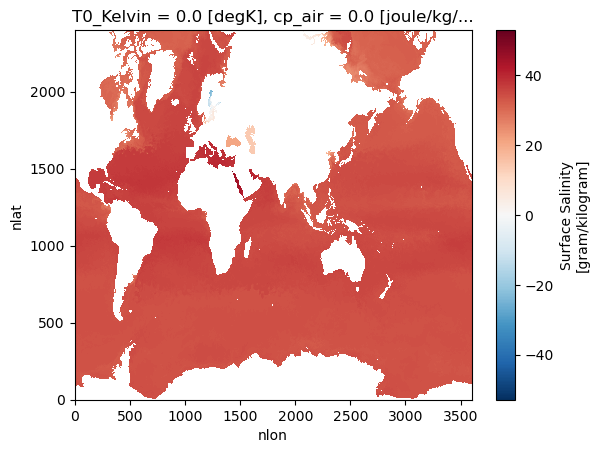

In [59]:
ds.SSS[0].where(mask).plot()

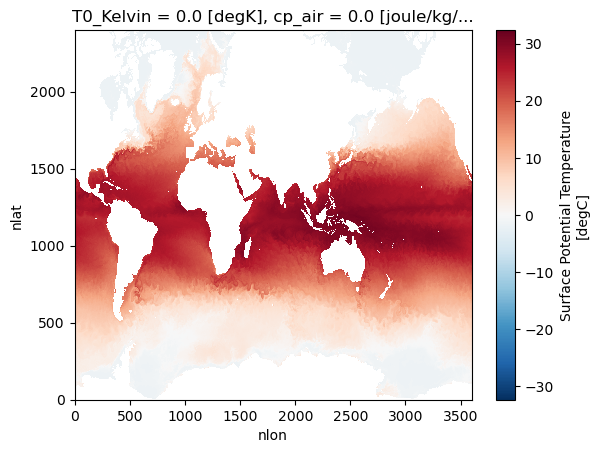

In [23]:
temp[0].plot()

In [72]:
t1 = tendency_terms.sst.sum(('nlat','nlon'))

In [73]:
t2 = tendency_terms.sst.where(mask).sum(('nlat','nlon'))

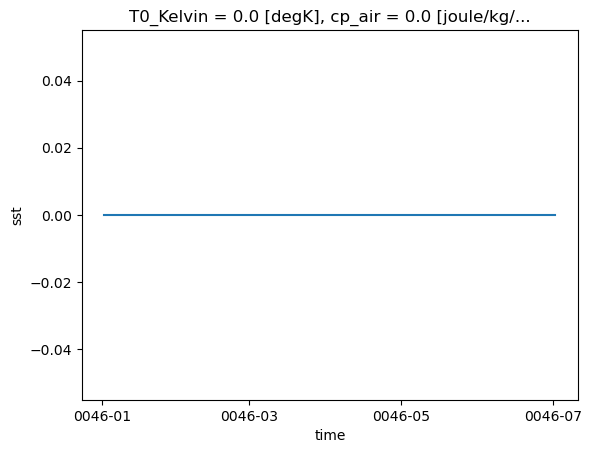

In [75]:
(t1-t2).plot()

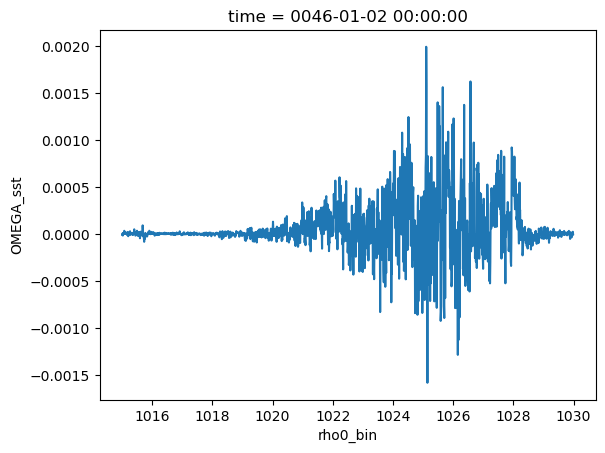

In [16]:
histograms.OMEGA_sst[0].plot()

In [ ]:
(histograms.OMEGA_rho[0] - rho_mask).plot()

In [84]:
rho_mask = histograms.OMEGA_rho[0]

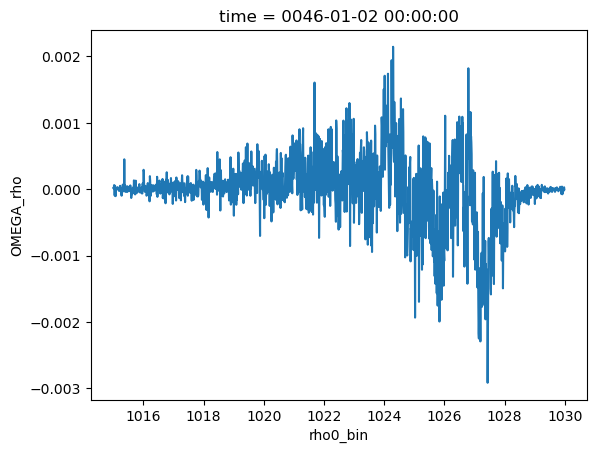

In [86]:
rho_mask.plot()

In [34]:
histograms.load()

<xarray.Dataset>
Dimensions:          (time: 182, rho0_bin: 1499)
Coordinates:
  * time             (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
Data variables:
    OMEGA_sst        (time, rho0_bin) float32 -8.42e-06 4.646e-06 ... 3.029e-06
    OMEGA_sss        (time, rho0_bin) float32 2.39e-05 2.489e-06 ... 2.95e-08
    OMEGA_rho        (time, rho0_bin) float32 1.56e-05 7.149e-06 ... 2.926e-06
    OMEGA_cabbeling  (time, rho0_bin) float32 -1.185e-07 -1.43e-08 ... 1.328e-07

# 2) Save histograms <a class='anchor' id='second-bullet'> </a>

In [35]:
#saving monthly climatology histograms
gcsmap_hist = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/histograms.zarr')
histograms.to_zarr(gcsmap_hist, mode='w')

2022-09-18 22:03:46,491 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.9/ssl.py", line 1310, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1129)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  F

[Back to top](#top)